In [1]:
!pip install mplcyberpunk

In [2]:
import shutil, os, subprocess
import json, random, cv2
from PIL import Image
from skimage.restoration import denoise_nl_means, estimate_sigma
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import random
from IPython.display import display
from pathlib import Path
import tempfile, pickle
import numpy as np
from torchvision import transforms
import torchvision.transforms as T
from sklearn.linear_model import LogisticRegression
import hdbscan
from sklearn.manifold import TSNE
import itertools
from sklearn.metrics import (silhouette_score,calinski_harabasz_score,davies_bouldin_score)
from sklearn.preprocessing import StandardScaler
import mplcyberpunk
from matplotlib.cm import tab10
import math, joblib
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
CFG = {
    "root_dir"    : Path("/content/drive/MyDrive/281_final_project/plane_classification_data"),
    "model_name"  : "facebook/dinov2-base",
    "batch_size"  : 64,
    "pca_dims"    : 100,
    "n_clusters"  : 4,
    "fp16"        : True
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def get_all_image_paths(root_dir):
    exts  = {".jpg"}
    return sorted(
        str(p) for p in root_dir.rglob("*")
        if p.suffix.lower() in exts
    )

image_paths = get_all_image_paths(CFG["root_dir"])
print(f"Total images found: {len(image_paths)}")

Total images found: 7033


In [6]:
proc  = AutoImageProcessor.from_pretrained(CFG["model_name"])
model = AutoModel.from_pretrained(
            CFG["model_name"],
            torch_dtype = torch.float16 if CFG["fp16"] else None
        ).eval().to(device)
model_dtype = next(model.parameters()).dtype
hidden_size = model.config.hidden_size

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
def load_rgb(path):
    return Image.open(path).convert("RGB")

In [8]:
N = len(image_paths)
features = torch.empty(N, hidden_size, dtype=torch.float32)
step = CFG["batch_size"]

# Layer View


In [9]:
#Layers
print("Num hidden layers:", model.config.num_hidden_layers)

for name, module in model.named_modules():
    print(name)

Num hidden layers: 12

embeddings
embeddings.patch_embeddings
embeddings.patch_embeddings.projection
embeddings.dropout
encoder
encoder.layer
encoder.layer.0
encoder.layer.0.norm1
encoder.layer.0.attention
encoder.layer.0.attention.attention
encoder.layer.0.attention.attention.query
encoder.layer.0.attention.attention.key
encoder.layer.0.attention.attention.value
encoder.layer.0.attention.output
encoder.layer.0.attention.output.dense
encoder.layer.0.attention.output.dropout
encoder.layer.0.layer_scale1
encoder.layer.0.drop_path
encoder.layer.0.norm2
encoder.layer.0.mlp
encoder.layer.0.mlp.fc1
encoder.layer.0.mlp.activation
encoder.layer.0.mlp.fc2
encoder.layer.0.layer_scale2
encoder.layer.1
encoder.layer.1.norm1
encoder.layer.1.attention
encoder.layer.1.attention.attention
encoder.layer.1.attention.attention.query
encoder.layer.1.attention.attention.key
encoder.layer.1.attention.attention.value
encoder.layer.1.attention.output
encoder.layer.1.attention.output.dense
encoder.layer.1.atte

In [11]:
def get_hidden_states(img_path):
    img = Image.open(img_path).convert("RGB")
    inputs = proc(img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states, img.size

In [12]:
def visualize_layer_features_grid(hidden_states, img_size, rows=2, cols=6):
    hs_layers = hidden_states[1:]
    assert len(hs_layers) == rows * cols, \
        f"Expected {rows*cols} layers, got {len(hs_layers)}"

    width, height = img_size
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        hs = hs_layers[i]           # hidden_states[1 + i]
        patch_feats = hs[0, 1:]     # drop CLS token
        P = patch_feats.size(0)
        g = int(math.sqrt(P))

        # mean over channels -> P
        single_map = patch_feats.mean(dim=-1)
        feat_map   = single_map.view(1, 1, g, g)

        # upsample to full image size
        up = F.interpolate(
            feat_map,
            size=(height, width),
            mode='bilinear',
            align_corners=False
        )

        ax.imshow(up[0, 0].cpu().numpy(), cmap='viridis')
        ax.set_title(f"Layer {i+1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

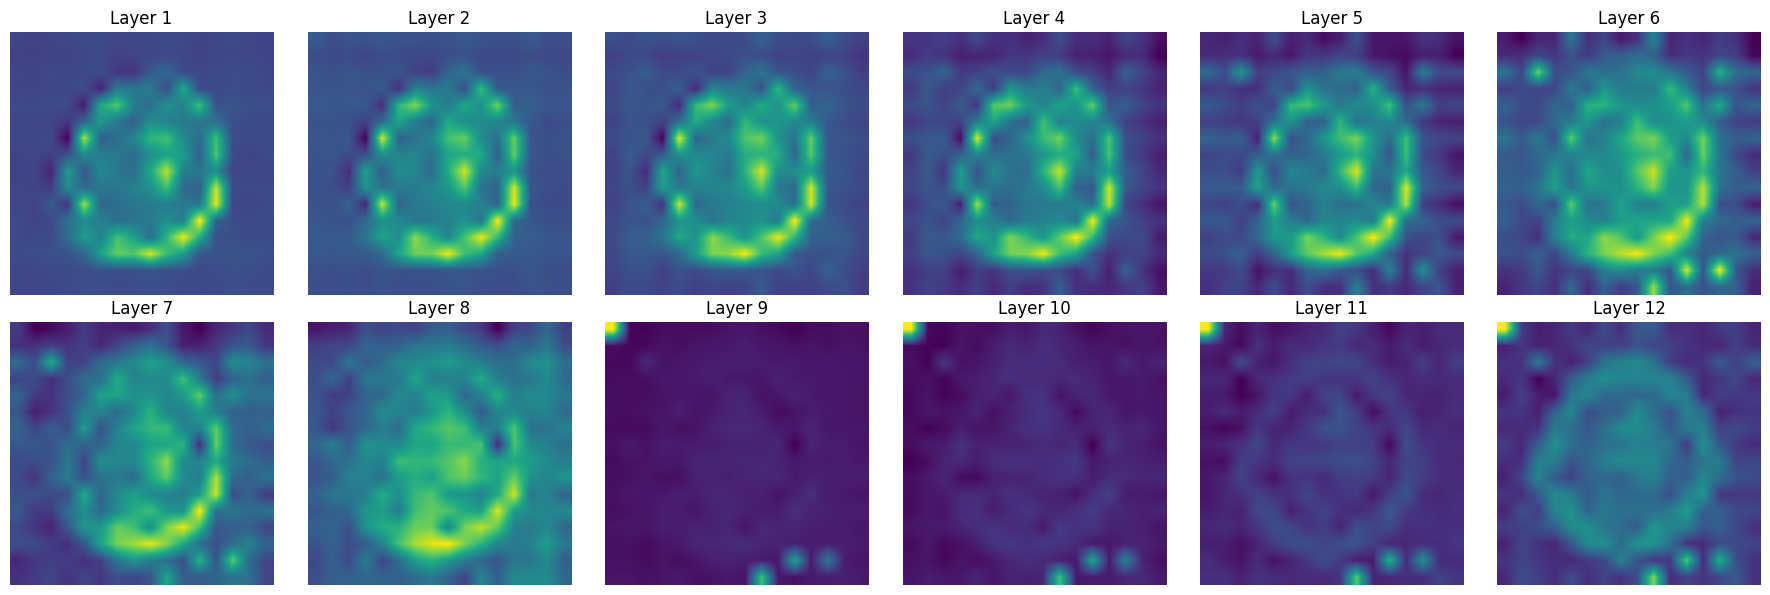

In [21]:
hs, img_size = get_hidden_states("/content/drive/MyDrive/281_final_project/plane_classification_data/Training/meningioma/Tr-me_1280.jpg")
visualize_layer_features_grid(hs, img_size, rows=2, cols=6)

# Ex


In [ ]:
with torch.no_grad(), torch.autocast("cuda", enabled=CFG["fp16"]):
    for start in range(0, N, step):
        end   = min(start + step, N)
        batch = [load_rgb(p) for p in image_paths[start:end]]

        inputs = proc(batch, return_tensors="pt")
        inputs = {k: v.to(device, dtype=model_dtype) for k, v in inputs.items()}

        feats  = model(**inputs).last_hidden_state[:, 0]
        features[start:end] = feats.float().cpu()

        print(f"\rExtracted: {end}/{N}", end="", flush=True)

print("\nFeature tensor shape:", tuple(features.shape))

Extracted: 7033/7033
Feature tensor shape: (7033, 768)


In [ ]:
scaler = StandardScaler()
pca    = PCA(n_components=CFG["pca_dims"], svd_solver="randomized", random_state=42)
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")

X = scaler.fit_transform(features.numpy())
X_pca = pca.fit_transform(X)
labels = kmeans.fit_predict(X_pca)

print("Cluster counts:", np.bincount(labels))

Cluster counts: [ 725 1701  976 1705 1926]


In [ ]:
def show_clusters(labels, image_paths, cluster_ids=None, num_samples=10, rng_seed=None):
    if cluster_ids is None:
        cluster_ids = sorted(np.unique(labels))

    rows = len(cluster_ids)
    rng  = np.random.default_rng(rng_seed)

    plt.figure(figsize=(1.6 * num_samples, 1.6 * rows))

    for r, cid in enumerate(cluster_ids):
        idxs = np.where(labels == cid)[0]
        if idxs.size == 0:
            continue

        chosen = rng.choice(idxs, size=min(num_samples, idxs.size), replace=False)

        for c, idx in enumerate(chosen):
            pos = r * num_samples + c + 1
            ax  = plt.subplot(rows, num_samples, pos)
            ax.imshow(Image.open(image_paths[idx]), cmap="gray")
            ax.set_xticks([]); ax.set_yticks([])

            ax.set_title(f"C {cid}", fontsize=8, pad=2)

            if c == 0:
                ax.set_ylabel(f"Cluster {cid}", rotation=90, fontsize=12, labelpad=8)

    plt.tight_layout()
    plt.show()


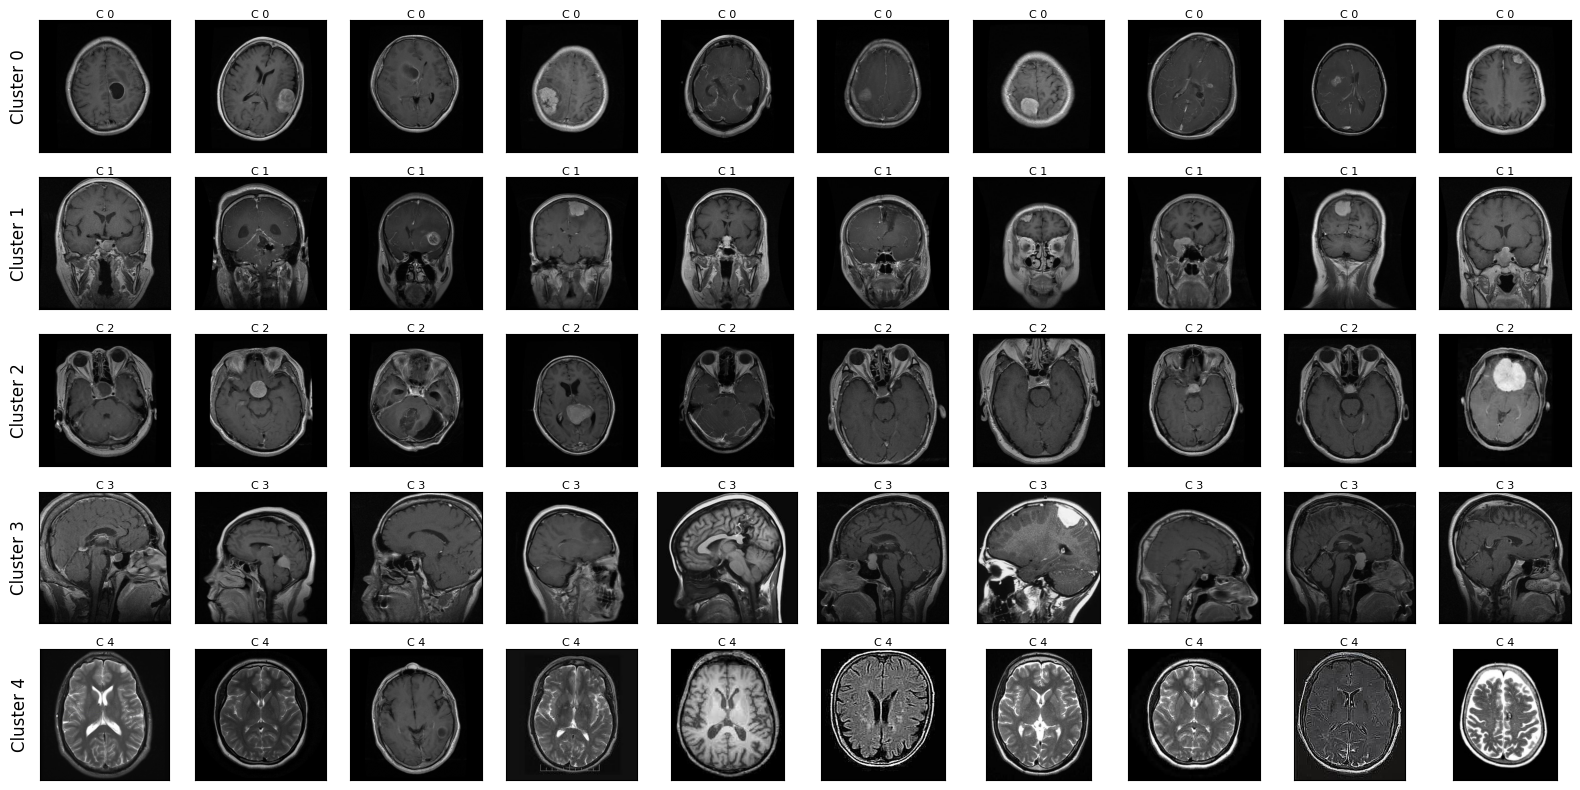

In [ ]:
show_clusters(labels, image_paths, cluster_ids=[0, 1, 2, 3, 4], num_samples=10, rng_seed=42)

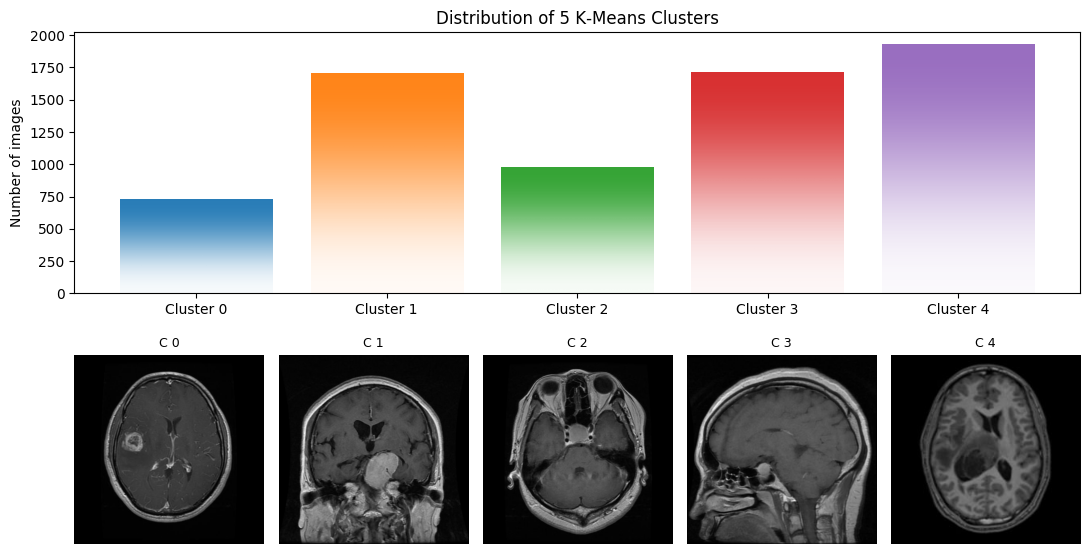

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
clusters       = unique.tolist()
n_clusters     = len(clusters)


sample_for = {}
for cid in clusters:
    idxs = np.where(labels == cid)[0]
    if idxs.size:
        sample_for[cid] = random.choice(idxs)

plt.figure(figsize=(2.2 * n_clusters, 6))

plt.subplot(2, 1, 1)
bars = plt.bar(
    clusters,
    counts,
    color=[f"C{i}" for i in clusters],
    tick_label=[f"Cluster {c}" for c in clusters]
)
mplcyberpunk.add_bar_gradient(bars)
plt.ylabel("Number of images")
plt.title("Distribution of 5 K‑Means Clusters")

for pos, cid in enumerate(clusters, start=1):
    plt.subplot(2, n_clusters, n_clusters + pos)
    img = Image.open(image_paths[sample_for[cid]])
    plt.imshow(img, cmap="gray")
    plt.title(f"C {cid}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


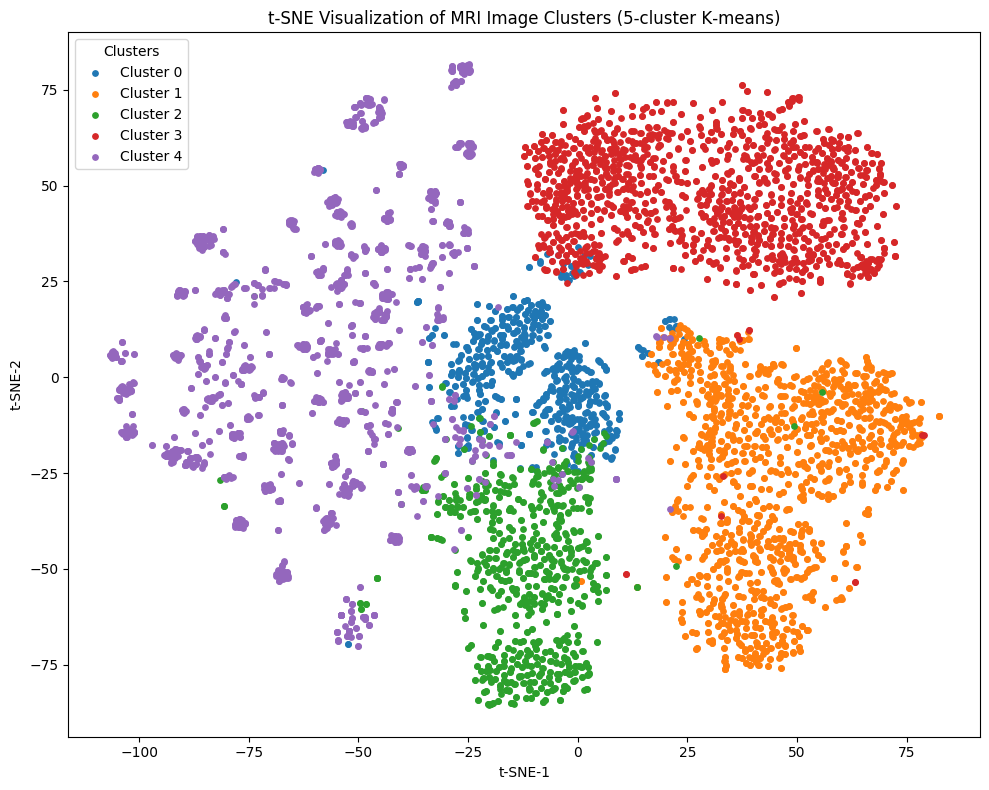

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_pca)


plt.figure(figsize=(10, 8))

clusters = np.unique(labels)
for cid in clusters:
    idx = labels == cid
    plt.scatter(tsne_results[idx, 0],
                tsne_results[idx, 1],
                label=f"Cluster {cid}",
                s=15)

plt.legend(title="Clusters")
plt.title("t‑SNE Visualization of MRI Image Clusters (5‑cluster K‑means)")
plt.xlabel("t‑SNE‑1")
plt.ylabel("t‑SNE‑2")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


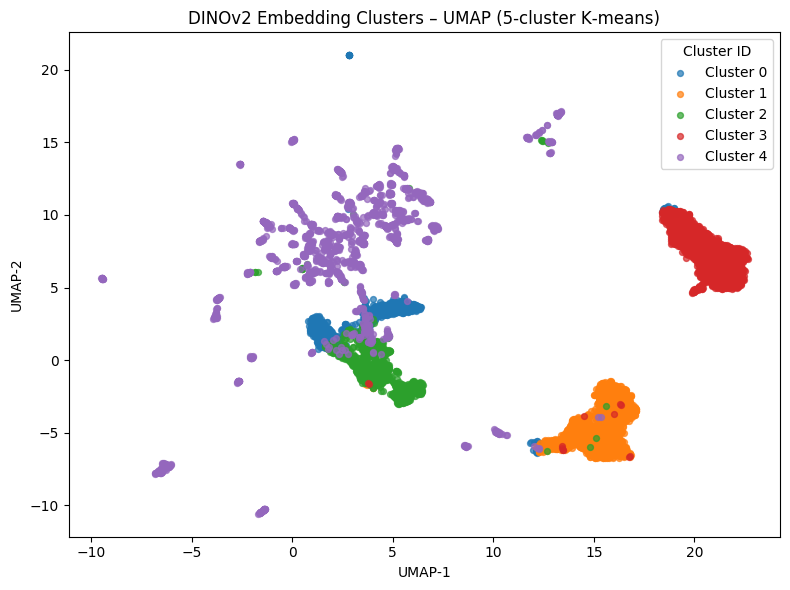

In [ ]:
X_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    random_state=42
).fit_transform(X_pca)

plt.figure(figsize=(8, 6))

clusters = np.unique(labels)
for cid in clusters:
    idx = labels == cid
    plt.scatter(
        X_umap[idx, 0], X_umap[idx, 1],
        s=18,
        color=tab10(cid),
        label=f"Cluster {cid}",
        alpha=0.7
    )

plt.title("DINOv2 Embedding Clusters – UMAP (5‑cluster K‑means)")
plt.xlabel("UMAP‑1")
plt.ylabel("UMAP‑2")
plt.legend(title="Cluster ID", loc="best")
plt.tight_layout()
plt.show()


#Remap cluster to have 3 clusters

In [ ]:
merge_map   = {0: 0, 2: 0, 4: 0, 1: 1, 3: 2}
labels3     = np.vectorize(merge_map.get)(labels)
clusters3   = sorted(np.unique(labels3))              # → [0,1,2]
n_clusters3 = len(clusters3)

In [ ]:
unique3, counts3 = np.unique(labels3, return_counts=True)
sample_for = {}
for cid in clusters3:
    idxs = np.where(labels3 == cid)[0]
    if idxs.size:
        sample_for[cid] = random.choice(idxs)

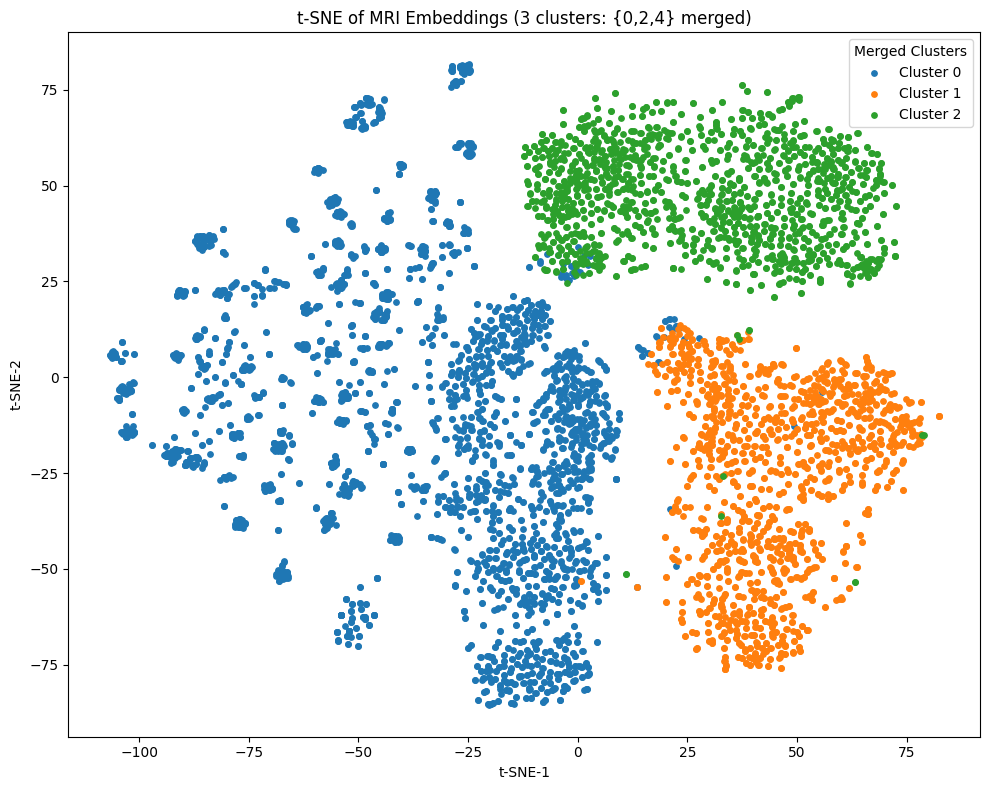

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 8))
for cid in clusters3:
    idx = labels3 == cid
    plt.scatter(tsne_results[idx, 0],
                tsne_results[idx, 1],
                label=f"Cluster {cid}",
                s=15)
plt.legend(title="Merged Clusters")
plt.title("t‑SNE of MRI Embeddings (3 clusters: {0,2,4} merged)")
plt.xlabel("t‑SNE‑1");  plt.ylabel("t‑SNE‑2")
plt.tight_layout()
plt.show()
